# Capstone Project - The Battle of Neighborhoods (Week 1)

## 1. A description of the problem and a discussion of the background. 

### Introduction of the City - Los Angeles

Los Angeles, officially the City of Los Angeles and often known by its initials L.A., is the largest city in California. With an estimated population of nearly four million people, it is the second-most populous city in the United States (after New York City) and the third-most populous city in North America (after Mexico City and New York City). Los Angeles is known for its Mediterranean climate, ethnic diversity, Hollywood entertainment industry, and its sprawling metropolis. Los Angeles lies in a basin in Southern California, adjacent to the Pacific Ocean, with mountains as high as 10,000 feet (3,000 m), and deserts. The city, which covers about 469 square miles (1,210 km2),is the seat of Los Angeles County, the most populous county in the United States. The Los Angeles metropolitan area (MSA) is home to 13.1 million people, making it the second-largest metropolitan area in the nation after New York. Greater Los Angeles includes metro Los Angeles as well as the Inland Empire and Ventura County.It is the second-most populous U.S. combined statistical area, also after New York, with a 2015 estimate of 18.7 million people.

### Business Problem

Coming down to business problem,I would like to open a restaurant near Santa Monica, which is one of the most beautiful cities in Los Angeles. As it is a famous tourist spot,there is already lots of attention towards it.I know there will be many competitors in terms of restauramt. But keeping them in mind, I need to locate my restaurant in place where more people are attracted and comfortable for a stay and a good meal.I want to bring foreign and local peoples attention towards my new hotel.I would like to flavour my retaurant recipe with Chinese and Japanese to grab their taste.
The challenge is to find a suitable location for opening a new restaurant attracted to all local and foreign people in the centre of all famous venues.

### Assumption

I assume that 85% local and 15% foreign peoples visit Santa Monica once in a year. Some people stay for couple of days or more. Also they find some place for hangout or a good meal. Their main focus might be belonging to stay somewhere near to reach venues. Apart from these set of people, students and working professionals are common audience here. So we may need to fascinate them all.

# Data Selection

We will be completely working on Foursquare data to explore and try to locate our new restaurant where more venues like church, temples, beach, museums, memorials that are present nearby.

We will looking for midpoint area of venues to locate our new restaurant. Before that our major focus will be on all venues present in and around the core place of Santa Monica.

Just a heads up on how many restaurant are distributed now around Santa Monica. We will perform some EDA on restaurants present in the tourist spot. On furthur notebook we will use Foursquare data to determine other venues as well.

# Data Preprocessing

### Import Libraries

In [2]:
# Import libraries
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("Libraries Imported")

Libraries Imported


### Credentials and Core location

In [12]:
CLIENT_ID = '3Z3ZIFG1GY2NGYXZ3AVE0DZKPAVVCQJHTENE4IR5OXJNTNPW' 
CLIENT_SECRET = 'J2WB5IYMG4AJCWMVF0ABC5SR1YRH3JOEQ2HOLBOGJE0TF5DB '
VERSION = '20200811'
LIMIT = 150

address = "Santa Monica, Los Angeles"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude    
longitude =location.longitude  

SM = 'Santa Monica location : {},{}'.format(latitude,longitude)
print(SM)

Santa Monica location : 34.0250724,-118.4965129


### Search Restaurants within 1 km

In [4]:
search_query_res = 'restaurant'
radius = 1000
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)

### Send the Get Request of Restaurants and Examine the Results

In [6]:
results_restaurant = requests.get(url_restaurant).json()

### Get Relevant Part of JSON and Transform it into a Pandas Dataframe

In [8]:
# assign relevant part of JSON to venues
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues_restaurant)

print("There are {} restaurants at Santa Monica".format(dataframe.shape[0]))

There are 16 restaurants at Santa Monica


### Define Information of Interest and Filter Dataframe

In [9]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
Restaurants_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
Restaurants_df.head()

,name,categories,distance,lat,lng,id
0,The Misfit Restaurant + Bar,American Restaurant,1076,34.015399,-118.496591,4da4bb1d0f578cfaafdbd518
1,Michael's Restaurant,American Restaurant,766,34.018740,-118.499770,4acfed0ff964a520e6d620e3
2,Restaurant chino Nan hai,Chinese Restaurant,795,34.019454,-118.491191,503a8c8ee4b0bbf1b03b7e1e
3,Simple Things Restaurant,American Restaurant,393,34.022205,-118.494011,5635381d498e8f8d6a6e9bf2
4,Romano's Restaurant,Food,520,34.026932,-118.501684,4f321f6719836c91c7b83bac


### Location of Restaurants

In [11]:
Restaurants_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Santa Monica

# add a red circle marker to represent the core location of Santa Monica
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Santa Monica',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(Restaurants_map)

# add the restaurants as blue circle markers
for lat, lng, label in zip(Restaurants_df.lat, Restaurants_df.lng, Restaurants_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(Restaurants_map)

# display map
Restaurants_map

Here are all contents for the Capstone Project - The Battle of Neighborhoods (Week 1), I will cover my code and report in the next Notebook. Thanks!

## 3. Data Analysis

### Distance between Restaurants and the Core Location

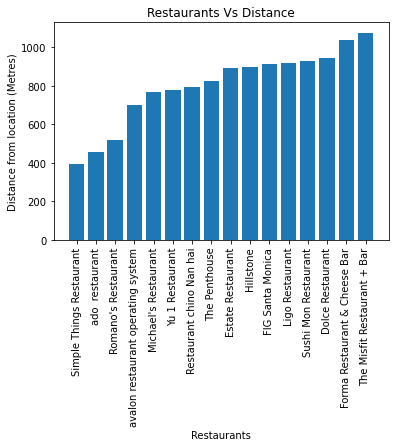

Average distance between restaurants and core location is 802 meters


In [16]:
distance_restaurant_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_restaurant_df.name))
    plt.bar(distance_restaurant_df.name, distance_restaurant_df.distance)
    plt.xlabel('Restaurants')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_restaurant_df.name,rotation=90)
    plt.title('Restaurants Vs Distance')
    plt.show()
plot_bar_x()

print("Average distance between restaurants and core location is {} meters".format(int(sum(Restaurants_df['distance'])/Restaurants_df.shape[0])))

From the plot above, we can find the following facts:
1. Simple Things Restaurant is has the cloesest distance to the core location of Santa Monica;
2. The Misfit Restaurant + Bar is the farthest among all restaurants;
3. The average distance between restaurants and core location is 802 metres.

## Explore for other venues around Santa Monica

In [17]:
radius=1000
url_venues = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [18]:
results_venues = requests.get(url_venues).json()
'There are {} venues around Santa Monica.'.format(len(results_venues['response']['groups'][0]['items']))

'There are 100 venues around Santa Monica.'

In [19]:
items_venues = results_venues['response']['groups'][0]['items']

In [68]:
dataframe_venues = pd.json_normalize(items_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe_venues.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_venues = dataframe_venues.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered_venues['venue.categories'] = dataframe_filtered_venues.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered_venues.columns = [col.split('.')[-1] for col in dataframe_filtered_venues.columns]

dataframe_filtered_venues

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Mendocino Farms,Sandwich Place,631 Wilshire Blvd,34.021229,-118.496065,"[{'label': 'display', 'lat': 34.02122889710969...",429,90401,US,Santa Monica,CA,United States,"[631 Wilshire Blvd, Santa Monica, CA 90401, Un...",NaN,NaN,56455453498e2e765346728d
1,Benny's Tacos & Chicken Rotisserie,Mexican Restaurant,915 Wilshire Blvd,34.023369,-118.493320,"[{'label': 'display', 'lat': 34.02336896060243...",350,90401,US,Santa Monica,CA,United States,"[915 Wilshire Blvd (Wilshire & 9th Ct), Santa ...",Wilshire & 9th Ct,NaN,5580affe498e0975d2009d02
2,Santa Monica Seafood,Seafood Restaurant,1000 Wilshire Blvd,34.023756,-118.492265,"[{'label': 'display', 'lat': 34.02375597395620...",418,90401,US,Santa Monica,CA,United States,"[1000 Wilshire Blvd (at 10th St.), Santa Monic...",at 10th St.,Santa Monica,49f8e126f964a520316d1fe3
3,Sidecar Doughnuts & Coffee,Coffee Shop,631 Wilshire Blvd,34.021135,-118.495803,"[{'label': 'display', 'lat': 34.02113475420749...",443,90401,US,Santa Monica,CA,United States,"[631 Wilshire Blvd (at 7th St), Santa Monica, ...",at 7th St,NaN,563683bd498e2c8761eb2ede
4,Huckleberry Cafe & Bakery,Café,1014 Wilshire Blvd,34.024002,-118.492095,"[{'label': 'display', 'lat': 34.02400201667549...",424,90401,US,Santa Monica,CA,United States,"[1014 Wilshire Blvd (at 10th Ct), Santa Monica...",at 10th Ct,NaN,49d046d0f964a520185b1fe3
5,Bluestone Lane,Café,631 Wilshire Blvd,34.021440,-118.495910,"[{'label': 'display', 'lat': 34.02144, 'lng': ...",408,90401,US,Santa Monica,CA,United States,"[631 Wilshire Blvd, Santa Monica, CA 90401, Un...",NaN,NaN,5ab4a38462420b3209f7511a
6,Onda,New American Restaurant,700 Wilshire Blvd,34.021344,-118.495056,"[{'label': 'display', 'lat': 34.021344, 'lng':...",436,90017,US,Los Angeles,CA,United States,"[700 Wilshire Blvd, Los Angeles, CA 90017, Uni...",NaN,NaN,5d990da9f665490008a50a35
7,Tocaya Organica,Mexican Restaurant,507 Wilshire Blvd,34.020251,-118.496992,"[{'label': 'display', 'lat': 34.0202511794541,...",538,90401,US,Santa Monica,CA,United States,"[507 Wilshire Blvd, Santa Monica, CA 90401, Un...",NaN,NaN,58f96576f0ca9540b1151125
8,Rori's Artisanal Creamery,Ice Cream Shop,910 Montana Ave,34.028677,-118.499492,"[{'label': 'display', 'lat': 34.02867679945021...",486,90403,US,Santa Monica,CA,United States,"[910 Montana Ave, Santa Monica, CA 90403, Unit...",NaN,North of Montana,5621e54c498effadee2314bc
9,Primo Passo Coffee Co.,Coffee Shop,702 Montana Ave,34.026899,-118.501634,"[{'label': 'display', 'lat': 34.02689877862753...",514,90403,US,Santa Monica,CA,United States,"[702 Montana Ave (at 7th St), Santa Monica, CA...",at 7th St,NaN,4f5bf0e6e4b024154290ec6b


## Extract Venues using Search Queries

In [38]:
# Data extracted from foursquare venues
four_sq_venue=pd.DataFrame(dataframe_filtered_venues[['name','categories','distance','lat','lng','id']])

# Data extracted from search queries
new_venues=pd.DataFrame(search_df)

# Concatenate both dataframe
df_venue=four_sq_venue
df_venue

,name,categories,distance,lat,lng,id
0,Mendocino Farms,Sandwich Place,429,34.021229,-118.496065,56455453498e2e765346728d
1,Benny's Tacos & Chicken Rotisserie,Mexican Restaurant,350,34.023369,-118.493320,5580affe498e0975d2009d02
2,Santa Monica Seafood,Seafood Restaurant,418,34.023756,-118.492265,49f8e126f964a520316d1fe3
3,Sidecar Doughnuts & Coffee,Coffee Shop,443,34.021135,-118.495803,563683bd498e2c8761eb2ede
4,Huckleberry Cafe & Bakery,Café,424,34.024002,-118.492095,49d046d0f964a520185b1fe3
5,Bluestone Lane,Café,408,34.021440,-118.495910,5ab4a38462420b3209f7511a
6,Onda,New American Restaurant,436,34.021344,-118.495056,5d990da9f665490008a50a35
7,Tocaya Organica,Mexican Restaurant,538,34.020251,-118.496992,58f96576f0ca9540b1151125
8,Rori's Artisanal Creamery,Ice Cream Shop,486,34.028677,-118.499492,5621e54c498effadee2314bc
9,Primo Passo Coffee Co.,Coffee Shop,514,34.026899,-118.501634,4f5bf0e6e4b024154290ec6b


In [39]:
to_drop = ['Restaurant','Diner','Kitchen']
df_venues = df_venue[~df_venue['categories'].str.contains('|'.join(to_drop))].reset_index()
print("There are {} venues in Santa Monica".format(df_venues.shape[0]))
df_venues[['name','distance','id']]

There are 76 venues in Santa Monica


,name,distance,id
0,Mendocino Farms,429,56455453498e2e765346728d
1,Sidecar Doughnuts & Coffee,443,563683bd498e2c8761eb2ede
2,Huckleberry Cafe & Bakery,424,49d046d0f964a520185b1fe3
3,Bluestone Lane,408,5ab4a38462420b3209f7511a
4,Rori's Artisanal Creamery,486,5621e54c498effadee2314bc
5,Primo Passo Coffee Co.,514,4f5bf0e6e4b024154290ec6b
6,Healthy Spot,507,49c7bd64f964a520b9571fe3
7,Caffe Luxxe,508,4a7488aaf964a5207bde1fe3
8,Rustic Canyon Wine Bar,486,459d1658f964a520a3401fe3
9,Father's Office,516,3fd66200f964a52002f01ee3


### Location of all venues

In [40]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Santa Monica
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='kanyakumari',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        #popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### Distance between Venues and the Core Location

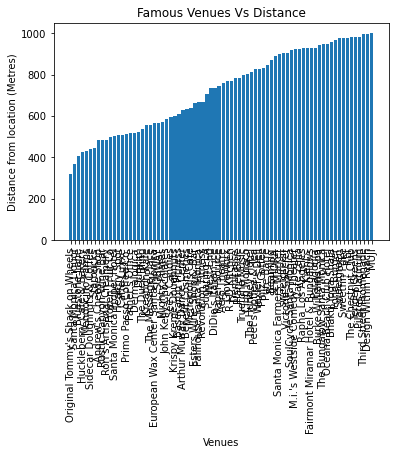

In [49]:
distance_venues_df=df_venues.sort_values('distance')

def plot_bar_venue():
    # this is for plotting purpose
    index = np.arange(len(distance_venues_df.name))
    plt.bar(distance_venues_df.name, distance_venues_df.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_venues_df.name,rotation=90)
    plt.title('Famous Venues Vs Distance')
    plt.show()
plot_bar_venue()

From the plot above, we can see that most of the venues are located between 500 to 700 meters from the core location.

### Clustering based on venues

In [71]:
final_venues = df_venues
# one hot encoding
neighbor_onehot = pd.get_dummies(final_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = final_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,Bed & Breakfast,Boutique,Boxing Gym,Burger Joint,Café,Candy Store,Cheese Shop,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Cosmetics Shop,Cycle Studio,Dance Studio,Deli / Bodega,Dessert Shop,Donut Shop,Farmers Market,Food Truck,Furniture / Home Store,Gastropub,Gift Shop,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Indie Movie Theater,Juice Bar,Lingerie Store,Liquor Store,Lounge,Massage Studio,Music Store,Nightclub,Pet Store,Pilates Studio,Poke Place,Salad Place,Sandwich Place,Shopping Plaza,Spa,Sporting Goods Shop,Wine Bar,Wine Shop,Yoga Studio
0,Mendocino Farms,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Sidecar Doughnuts & Coffee,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Huckleberry Cafe & Bakery,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bluestone Lane,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Rori's Artisanal Creamery,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [73]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [74]:
# Clustering

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clustersss', kmeans.labels_)

neighbor_merged = final_venues

# merge grouped with data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(n_clusters=3, random_state=0)

### Center of all clusters & Midpoint of all venues

In [76]:
fin=neighbor_merged.groupby(['Clustersss']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest restaurant
venues_lan=sum(final_venues.lat)/len(final_venues.lat)
venues_lng=sum(final_venues.lng)/len(final_venues.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of our brand new restaruant:{},{}".format(final_latitude,final_longitude))

Final location (Green Dot in our below given map) of our brand new restaruant:34.023760677337236,-118.49650183994382


In [78]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

## Discussion

Although there are a lot of competition between each restaurant in Santa Monica, KMeans have figured out the most common place for all the venues. This output was very adjacent to the core location.This proves the accurate spotting of our predicted algorithm.

The aim of the restaurant is to provide the best experience to its customers; therefore, in this final location, customers can reach each famout and popular venues in Santa Monica very convenient. I believe that the location will bring a huge success to the new restaurant.

## Conclusion

My restaurant location
Final location is pointed at 34.023760677337236,-118.49650183994382
The final location for the new restaurant can give easy access for our customers to all tourist in Santa Monica.
Located at between the school and memorial playhouse which can give more attention to people who passby.


As a business person,one would be able to set up a restaurant on given spot. This will bring revenue automatically as we have located in very near to core one. We proved this with Kmeans.